# BiLSTM Model

## 1. Import libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('./Data/Gold_Futures_Cleaned.csv', index_col='Date', parse_dates=True, usecols=['Date','Price', 'Open', 'High','Low'])
# df.sort_values(by='Date', ascending=True, inplace=True)
# df.reset_index(inplace=True)

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'Price' từ tập dữ liệu huấn luyện
y_train = train_data['Price']
y_test = test_data['Price']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'GLD'
X_train = train_data.drop(columns=['Price'])
X_test = test_data.drop(columns=['Price'])

Shape of data train (3132, 4)
Shape of data test (783, 4)


## 3. Dataset overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3915 entries, 2010-01-04 to 2025-05-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3915 non-null   float64
 1   Open    3915 non-null   float64
 2   High    3915 non-null   float64
 3   Low     3915 non-null   float64
dtypes: float64(4)
memory usage: 152.9 KB


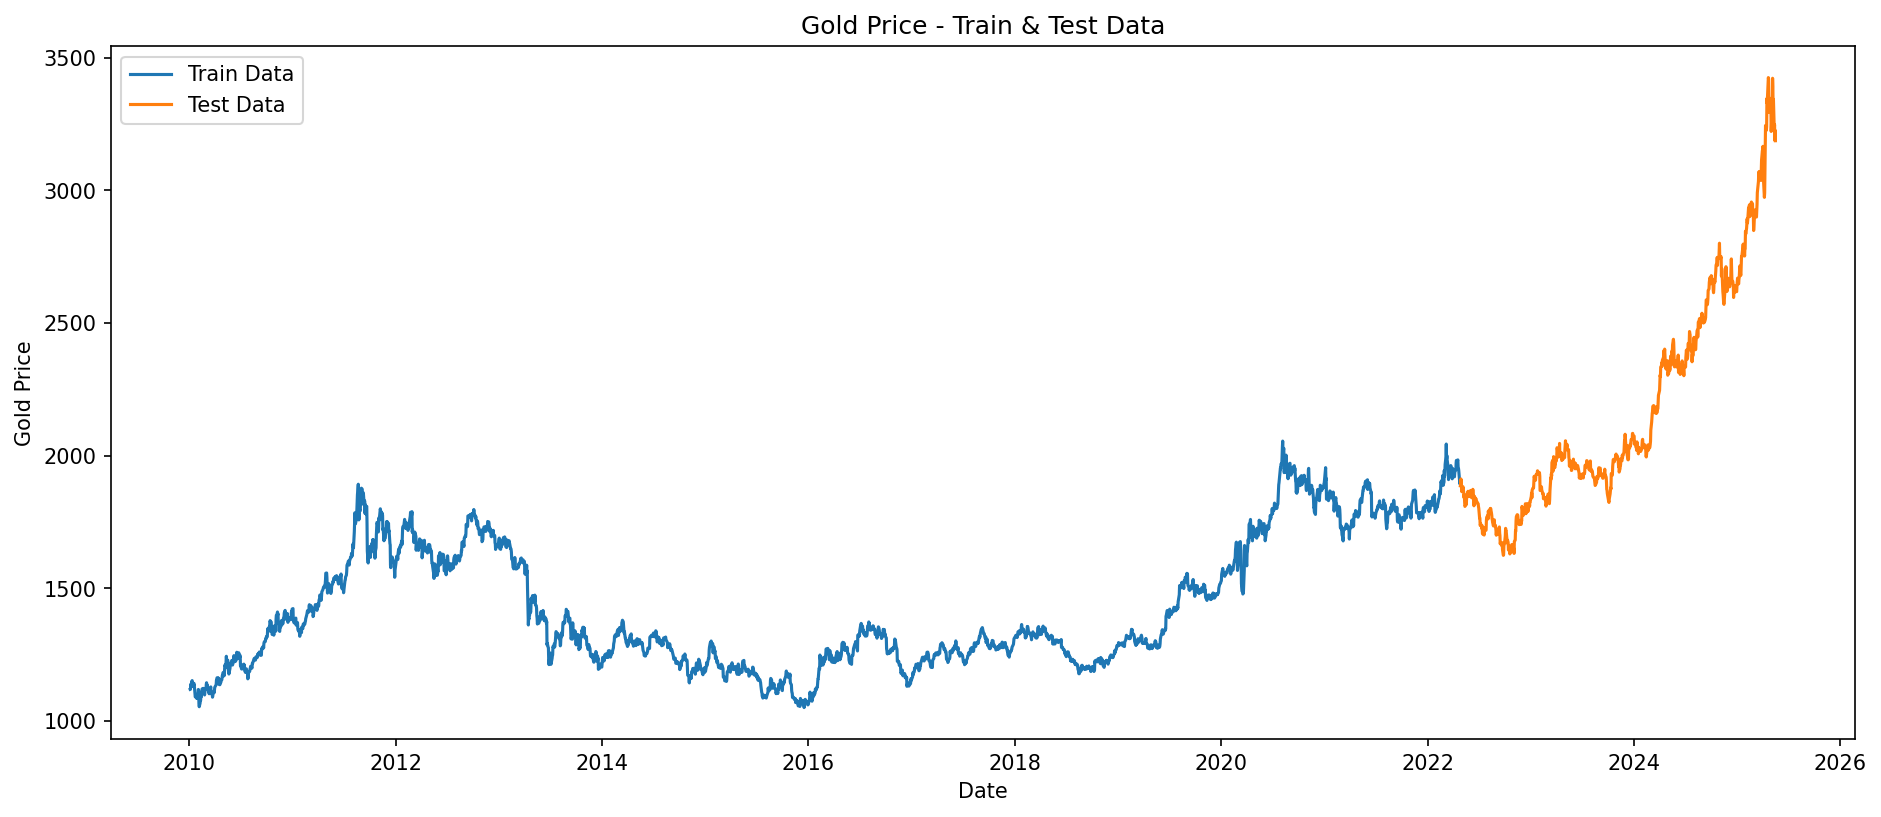

In [4]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['Price'], label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['Price'], label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

## 4. Thông tin chi tiết của tập Train và Test

In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2010-01-04 to 2022-04-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3132 non-null   float64
 1   Open    3132 non-null   float64
 2   High    3132 non-null   float64
 3   Low     3132 non-null   float64
dtypes: float64(4)
memory usage: 122.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2022-04-27 to 2025-05-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   783 non-null    float64
 1   Open    783 non-null    float64
 2   High    783 non-null    float64
 3   Low     783 non-null    float64
dtypes: float64(4)
memory usage: 30.6 KB


## 5. Khởi tạo và huấn luyện mô hình BiBiLSTM

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Input, Bidirectional, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_price = MinMaxScaler(feature_range=(0, 1))
# Chuẩn hóa toàn bộ dữ liệu đầu vào
scaled_data = scaler.fit_transform(df[['Price', 'Open', 'High', 'Low']])
# Chuẩn hóa riêng cột 'Price' để dùng sau khi dự đoán
scaler_price.fit(df[['Price']]) 

MinMaxScaler()

In [8]:
# Tạo hàm chia dữ liệu thành chuỗi
def create_sequences(data, target_index, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, target_index])
    return np.array(sequences), np.array(labels)

In [9]:
# Thiết lập tham số
# Độ dài chuỗi đầu vào (số bước thời gian nhìn lại để dự đoán bước tiếp theo)
sequence_length = 10
target_index = df.columns.get_loc('Price')  # Vị trí cột 'Price' trong scaled_data

# Tách dữ liệu đã chuẩn hóa theo tỷ lệ train/test như ban đầu
train_scaled = scaled_data[:len(train_data)]
test_scaled = scaled_data[len(train_data):]

# Tạo tập train và test
X_train, y_train = create_sequences(train_scaled, target_index, sequence_length)
X_test, y_test = create_sequences(test_scaled, target_index, sequence_length)

In [10]:
# Xây dựng mô hình BiLSTM

# Khởi tạo mô hình Sequential
model = Sequential()

# Thêm lớp Input để xác định hình dạng đầu vào
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Xây dựng mô hình BiLSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

#compile mô hình
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
# Thiết lập cơ chế dừng sớm để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0036 - val_loss: 4.7260e-04
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8896e-04 - val_loss: 3.7659e-04
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8791e-04 - val_loss: 9.7006e-04
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3511e-04 - val_loss: 5.0383e-04
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3297e-04 - val_loss: 2.3465e-04
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9362e-04 - val_loss: 1.8045e-04
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8433e-04 - val_loss: 3.1247e-04
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2903e-04 - val_loss: 5.5813e-04
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7143e-04 - val_loss: 1.9335e-04
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.4064e-04 - val_loss: 4.0359e-04
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3769e-04 - 

### 6. Dự đoán và tính toán các độ đo

In [12]:
# Dự đoán trên tập test
predictions = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [13]:

# Tạo cột giả với các giá trị 0 có kích thước phù hợp với predictions
dummy_features = np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))

# Nối cột dự đoán vào cột giả
predictions_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features, predictions])
)[:, -1]

# Rescale y_train về giá trị gốc
dummy_features_train = np.zeros((y_train.shape[0], scaled_data.shape[1] - 1))
y_train_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features_train, y_train.reshape(-1, 1)])
)[:, -1]

# Tương tự cho y_test
dummy_features_test = np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))

y_test_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features_test, y_test.reshape(-1, 1)])
)[:, -1]
predictions_rescaled = scaler_price.inverse_transform(predictions)

In [14]:
# Tính chỉ số
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 76.05752921634763
MAPE: 2.9348093166849525%
RMSE: 126.72360554129806
R²: 0.9079277571766674


### 7. Biểu đồ dự đoán của mô hình

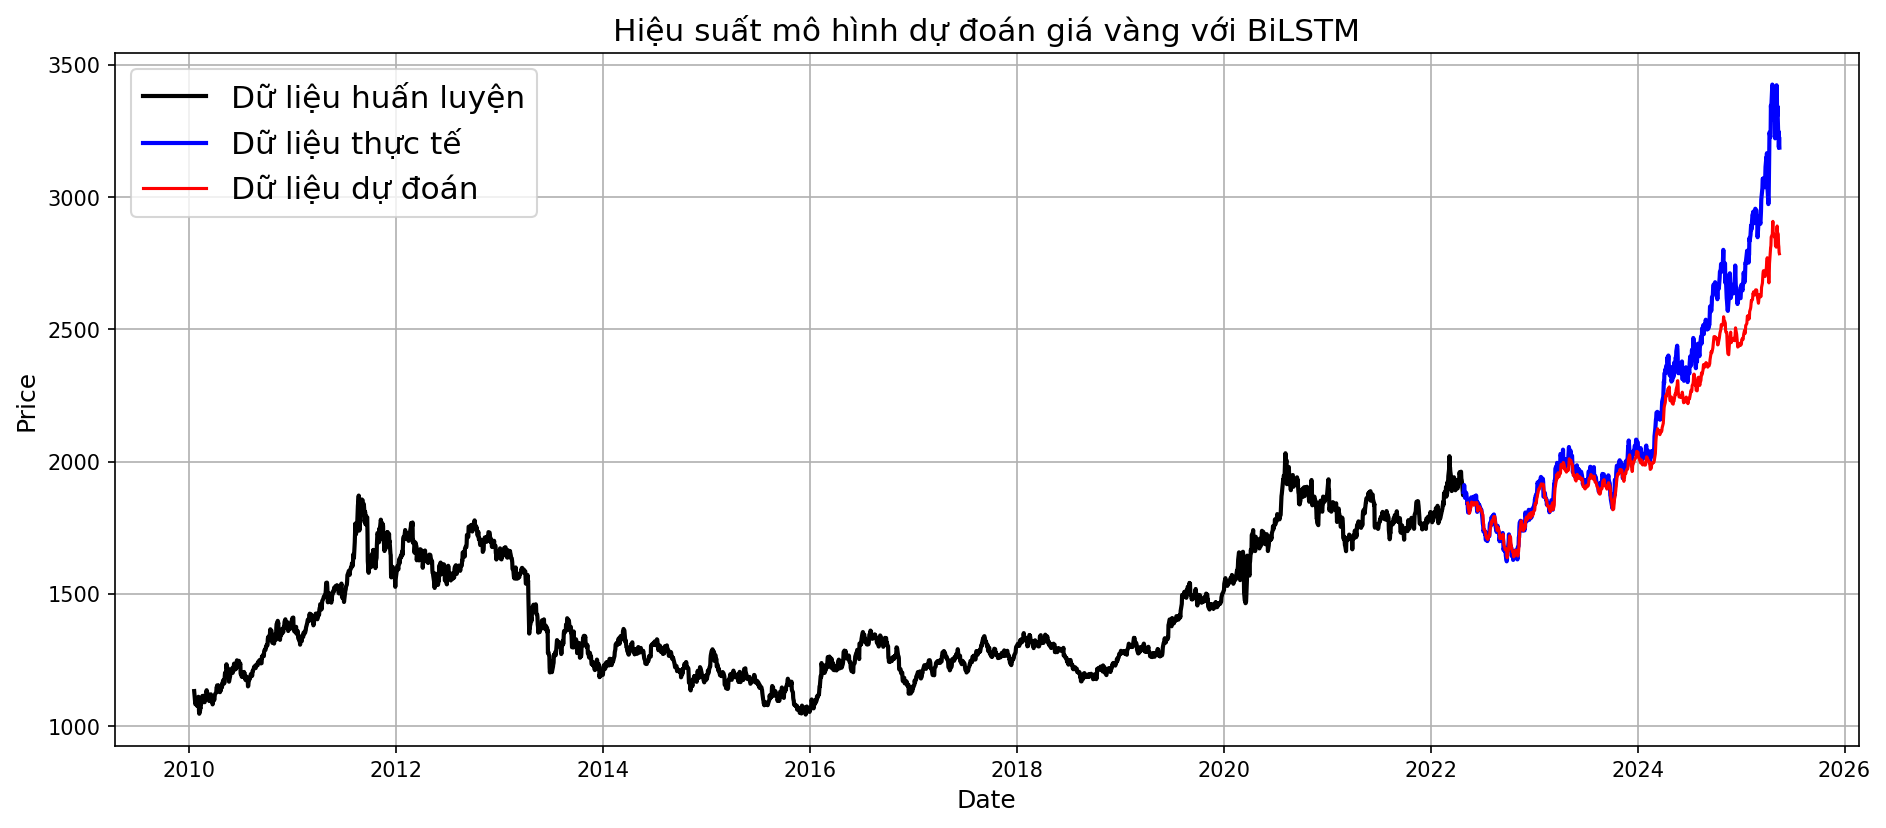

In [15]:
plt.figure(figsize=(15, 6), dpi=150)

# Sau đó vẽ lại dữ liệu huấn luyện
plt.plot(train_data.index[sequence_length:], y_train_rescaled, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu thực tế (test set)
plt.plot(test_data.index, test_data['Price'], label='Dữ liệu thực tế', lw=2, color='blue')

# Vẽ dữ liệu dự đoán (dùng sequence_length để căn chỉnh)
plt.plot(test_data.index[sequence_length:], predictions_rescaled, label='Dữ liệu dự đoán', color='red')

# Thêm tiêu đề và nhãn
plt.title('Hiệu suất mô hình dự đoán giá vàng với BiLSTM', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)

# Hiển thị legend
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], prop={'size': 15})

# Hiển thị biểu đồ
plt.show()
